In [1]:
# Only need to do this the first time, then restart the kernel
%pip install photutils --no-deps

Note: you may need to restart the kernel to use updated packages.


In [2]:
#run startup.py
import importlib as im
import numpy as np
import scipy as sp
import imageio as im
# %matplotlib inline
# conda update astropy
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'
import matplotlib.pyplot as plt
from scipy import ndimage
from astropy.io import fits
from astropy.io.fits import getheader
from astropy.io.fits import getdata
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)

from astropy.stats import sigma_clipped_stats
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus

In [3]:
pos_star = [[566.271833, 527.936605], [564.179743, 525.161502], [580.455309, 522.959352], [591.524384, 527.588695], [605.541445, 524.260185], [473.58807, 480.066184], [482.942919, 481.020788], [489.591759, 529.464778], [522.070347, 523.116215], [566.7875, 530.628676], [564.379407, 528.191835], [591.473943, 525.506587], [575.757426, 522.095544], [566.591891, 533.040644], [565.697411, 529.129683], [584.533221, 526.198837], [592.137812, 535.173836], [603.674376, 527.320067], [583.20903, 527.321265], [596.494568, 525.105032], [605.656838, 523.716367], [592.073448, 542.607572], [517.416317, 484.147732], [514.349722, 487.586812], [499.874923, 515.974508], [494.38808, 493.349839], [496.037151, 546.064538], [554.148421, 532.378092], [573.276808, 549.802774], [596.161736, 541.88794], [590.971649, 552.485902], [614.45019, 535.10502], [601.958823, 558.13553], [547.811216, 521.972934], [512.579441, 505.133026], [488.669855, 494.070359], [534.14095, 535.778585], [559.610713, 537.471869], [585.566827, 535.486446], [612.221246, 546.598948], [589.291915, 541.592955], [513.0159, 482.986998], [499.223556, 468.75348], [535.933712, 532.375619], [570.787001, 537.285682], [568.944762, 545.640419], [587.668823, 545.118777], [602.825815, 550.203918], [607.190896, 540.731964]]
pos_ref = [[822.430131 , 584.68482], [308.077216 , 468.378252], [324.385778 , 466.205276], [335.451584 , 470.647248], [349.567295 , 467.340499], [720.518506 , 550.552141], [730.331612 , 551.490416], [736.998992 , 599.800952], [769.047556 , 593.523368], [822.618145 , 587.301288], [308.331841 , 471.426071], [335.707294 , 468.981013], [319.668466 , 465.033751], [822.483991 , 589.957358], [309.533966 , 472.407225], [328.33896 , 469.488376], [335.725117 , 478.477722], [347.177202 , 470.353315], [327.315468 , 470.635486], [340.517163 , 468.313869], [349.638612 , 466.772921], [336.364428 , 485.784926], [270.06698 , 414.084254], [761.532804 , 558.113392], [746.990045 , 586.411777], [742.072639 , 564.167696], [742.840673 , 616.209796], [810.178967 , 589.241318], [317.129559 , 493.120804], [340.084377 , 485.282904], [334.797697 , 495.854674], [358.234234 , 478.172327], [346.020217 , 501.372235], [794.982289 , 592.494029], [760.097591 , 575.714367], [735.765881 , 564.917447], [780.696364 , 606.199684], [806.412317 , 607.867548], [841.91132 , 592.439512], [355.579578 , 489.995935], [333.15668 , 484.749682], [760.181303 , 553.37974], [746.508046 , 539.164678], [783.330994 , 602.548269], [826.752817 , 593.963945], [312.925913 , 488.778533], [331.467176 , 488.360801], [346.880125 , 493.345267], [350.753341 , 484.032719]]

In [7]:
#get file that contains name of files to look at
dt=np.dtype([('filename', np.compat.unicode, 20)])
files=np.genfromtxt("files.txt",dtype=dt)
infiles=files['filename']

times = [] #look at JD for each picture
mags_var = [] #get mag of var star
mags_ref = [] #get mag of reference star
SNR = []

for i in range (0,len(infiles)):
    
    aperture = CircularAperture([pos_star[i],pos_ref[i]], r=7.) #set up aps for both stars
    #back_aper = CircularAnnulus([pos_star[i],pos_ref[i]], r_in=13., r_out=20.) #set up aps for both stars
    
    sci_fn = "wasp_19/reduced/"+infiles[i]
    sci_hdulist = fits.open(sci_fn)
    data = sci_hdulist[0].data.astype(np.float64)
    
    dark_fn = "wasp_19/callibration/Prompt5_mbias_621095.fits"
    dark_hdulist = fits.open(dark_fn)
    dark = sci_hdulist[0].data.astype(np.float64)
    
    #aperstats = ApertureStats(data, back_aper) #aperature stats not working
    mean, bkg_median, std = sigma_clipped_stats(data, sigma=3.0)
    
    # Now do the photometry
    phot_table = aperture_photometry(data - bkg_median, aperture)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    
    
    Nstar = phot_table["aperture_sum"][0]
    Nbackpp = bkg_median
    Nthermpp = aperture_photometry(dark, aperture)["aperture_sum"][0]
    R = sci_hdulist[0].header["RDNOISE"]
    npix = 1024*1024
    
    noise = np.sqrt(Nstar + (Nbackpp*npix) + (Nthermpp*npix) + (R*R*npix))
    SNR.append(Nstar/noise)
    
    
    #convert to magnitude
    mag = -2.5* np.log10(phot_table['aperture_sum']) + 21
    phot_table['magnitudes'] = mag
    phot_table['magnitudes'].info.format = '%.8g'  # for consistent table output
    print(phot_table)
    
    #put magnitudes and times into arraies
    mags_var.append(phot_table["magnitudes"][0])
    mags_ref.append(phot_table["magnitudes"][1])
    
    times.append(sci_hdulist[0].header["JD"])

 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 566.271833 527.936605    16580.117  10.451031
  2 822.430131  584.68482    5779.8313  11.595212
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 564.179743 525.161502    17272.997  10.406581
  2 308.077216 468.378252    5746.2264  11.601543
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 580.455309 522.959352    16988.207  10.424631
  2 324.385778 466.205276    5769.4797  11.597158
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 591.524384 527.588695    16279.429  10.470902
  2 335.451584 470.647248    5434.3489  11.662131


 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 512.579441 505.133026     15764.73  10.505784
  2 760.097591 575.714367    5342.8684  11.680564
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 488.669855 494.070359    16454.325    10.4593
  2 735.765881 564.917447     5586.473  11.632156
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1  534.14095 535.778585     15387.87  10.532054
  2 780.696364 606.199684    4754.3839  11.807264
 id  xcenter    ycenter   aperture_sum magnitudes
       pix        pix                            
--- ---------- ---------- ------------ ----------
  1 559.610713 537.471869    14370.869  10.606292
  2 806.412317 607.867548    4598.9483  11.843354


In [8]:
print(SNR)

[0.1185951765122571, 0.12196782777830997, 0.12113653138475243, 0.11879613449446208, 0.11709905676086277, 0.12453243219414453, 0.1282239230721327, 0.12836367410661326, 0.12457802837231315, 0.12007001080701912, 0.11988559331810775, 0.12022300393271822, 0.11380782770418969, 0.12655849808536357, 0.12806210208711558, 0.12974407429270354, 0.1278634459019596, 0.11225096278447547, 0.12886595974020795, 0.1269700766586976, 0.12077916869432016, 0.11592272347888871, 0.11482971771200892, 0.11603546882704434, 0.11694381742190813, 0.11326082481701986, 0.10903545691919206, 0.1270829072548034, 0.12972257515791388, 0.1312275870768824, 0.128497282280307, 0.12292949148775316, 0.11905748582412727, 0.1165459988003175, 0.11507330995262337, 0.11884580043321, 0.11564920238942962, 0.13005401205599634, 0.1296890406905102, 0.11216632610368973, 0.11910184057692567, 0.13305152273893303, 0.1311736714797769, 0.1339345871516179, 0.1290929261807496, 0.12803186072105177, 0.12411012538441482, 0.12936210547046484, 0.12160

In [9]:
print(np.mean(SNR))

0.12266142551506203


In [10]:
print(times)

[2459693.48886563, 2459693.54536188, 2459693.59133653, 2459693.64621683, 2459693.69060767, 2459694.0515166, 2459694.0984871, 2459694.14457603, 2459694.18844194, 2459694.48839384, 2459694.53418431, 2459694.61748022, 2459694.71562133, 2459695.49488714, 2459695.54146536, 2459695.58921747, 2459695.63507787, 2459695.68616366, 2459697.56959199, 2459697.61601619, 2459697.67294226, 2459697.71678609, 2459697.9717675, 2459698.02185167, 2459698.0650003, 2459698.10772551, 2459698.16204769, 2459698.48561196, 2459698.5335942, 2459698.58080712, 2459698.62492995, 2459698.66964806, 2459698.71370176, 2459698.97985501, 2459699.02325093, 2459699.07399122, 2459699.12338193, 2459699.18067076, 2459699.48706352, 2459699.65748887, 2459699.70756641, 2459700.02486802, 2459700.07411086, 2459700.12101883, 2459700.49694703, 2459700.54689596, 2459700.59837338, 2459700.64263705, 2459700.6875883]


In [11]:
print(mags_var)

[10.45103105114364, 10.406580773707416, 10.424631127978406, 10.470902065825076, 10.497989330229862, 10.485107714278458, 10.463990971717976, 10.52048842549263, 10.609689856735422, 10.488169411134866, 10.501675044129069, 10.472179857543793, 10.569943818789742, 10.507571484240444, 10.497856221878562, 10.480494993906028, 10.517035639904277, 10.601216754162751, 10.448857359888649, 10.47302142882396, 10.524648511139887, 10.594354392643199, 10.4400340553905, 10.455770418769625, 10.476295731666202, 10.552129387255384, 10.655676999166346, 10.472682534615638, 10.441073541392793, 10.423224293169401, 10.48050911534903, 10.474634228633192, 10.53456453572478, 10.453792312135594, 10.505783675588619, 10.45929982462377, 10.532053753703613, 10.606292428610876, 10.40157930479884, 10.737211448250086, 10.497886985619644, 10.451623969183602, 10.515927754588072, 10.501836049704394, 10.433052821711453, 10.46897510419687, 10.551332588821351, 10.467266244680069, 10.471925370214638]


In [12]:
print(mags_ref)

[11.595212092729367, 11.601543158597046, 11.597158372933084, 11.662131197274428, 11.684980086433782, 11.626853394205568, 11.676754662360967, 11.737190943339394, 11.82343987645748, 11.64904493941399, 11.660538715504748, 11.677489049776215, 11.778625110545416, 11.65665992435521, 11.647322743462613, 11.637847191118913, 11.70057805872642, 11.76832958272814, 11.653706425333866, 11.61507308039346, 11.636504974365256, 11.765553230910928, 11.645385512265808, 11.686701026857277, 11.66866209970958, 11.729060596035572, 11.921660941559605, 11.638871319710374, 11.606149120426409, 11.615613458194629, 11.69324380995531, 11.653999330192395, 11.705127863423419, 11.618437927691147, 11.680563812307245, 11.632155739569033, 11.807264374390039, 11.843353687716279, 11.576891743066597, 11.910792717299618, 11.720141696887547, 11.627208526677158, 11.650692265906637, 11.645846111134222, 11.574662621144912, 11.664425559594518, 11.69063911670886, 11.620169482714457, 11.638625113031065]


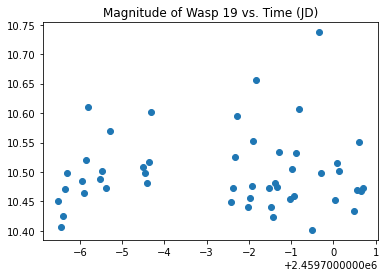

In [18]:
plt.title("Magnitude of Wasp 19 vs. Time (JD)")
plt.scatter(times, mags_var)

In [14]:
period = 0.85
time_fix = []
time_fix.append(0)
for i in range (1,len(times)):
    fix = (times[i] - times[0]) % period
    time_fix.append(fix)

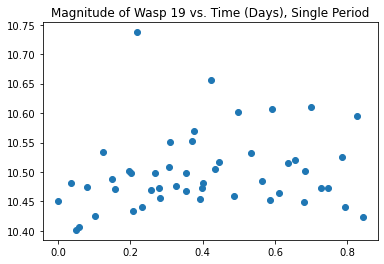

In [20]:
plt.title("Magnitude of Wasp 19 vs. Time (Days), Single Period")
plt.scatter(time_fix, mags_var)

In [16]:
true_ref_mag = 12 #test value since struggling with open filter
mags_fix = []
mags_ref_fixed = []
mags_var_fixed = []

for i in range (0, len(mags_ref)):
    mags_fix.append(true_ref_mag - mags_ref[i])
    
    mags_ref_fixed.append(mags_ref[i] + mags_fix[i])
    mags_var_fixed.append(mags_var[i] + mags_fix[i])
#this isnt working right now

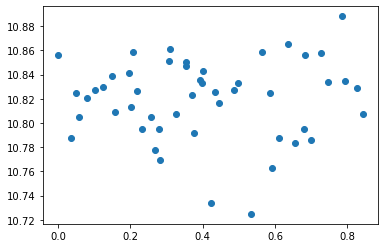

In [17]:
plt.scatter(time_fix, mags_var_fixed)